In [1]:
import pandas as pd

# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files (전처리)
startup_ml_df = read_csv_auto_dates("./ml_join/startup_ml_df.csv")
#acq = read_csv_auto_dates("./clean_data_v1/clean_acquisitions_final.csv")
#deg = read_csv_auto_dates("./clean_data_v1/clean_degrees_final.csv")
frs = read_csv_auto_dates("./clean_data_v1/clean_fr_final.csv")
#fds = read_csv_auto_dates("./clean_data_v1/clean_funds_final.csv")
inv = read_csv_auto_dates("./clean_data_v1/clean_investments_final.csv")
#ipo = read_csv_auto_dates("./clean_data_v1/clean_ipos_final.csv")
mil = read_csv_auto_dates("./clean_data_v1/clean_milestones_final.csv")
obj = read_csv_auto_dates("./clean_data_v1/clean_objects_final.csv")
#peo = read_csv_auto_dates("./clean_data_v1/clean_people_final.csv")
#off = read_csv_auto_dates("./clean_data_v1/clean_offices_final.csv")
rel = read_csv_auto_dates("./clean_data_v1/clean_relationships_final.csv")

# 통계 테이블 가져오기
success_master = read_csv_auto_dates("./statistic_join/success_master.csv")
startup_ml_result = read_csv_auto_dates("./ml_join/startup_ml_result.csv")

print("="*60)
print("Dataset 로드 완료!")
print("="*60)

Dataset 로드 완료!


In [2]:
startup_ml_result

,objects_cfpr_id,category,city,n_offices,relationships,degree_level,subject,inst,n_founding,is_degree_level_missing,is_n_offices_missing,is_n_founding_missing,degree_level_filled,category_4,log1p_n_offices,log1p_n_founding,log1p_relationships,cluster,success_flag
0,c:1,web,seattle,2.0,17,2.0,Computer Science / Software,"california, berkeley university",2.0,0,0,0,2,digital product,1.098612,1.098612,2.890372,1,1
1,c:10,games_video,culver city,1.0,6,2.0,Computer Science / Software,michigan university,2.0,0,0,0,2,digital product,0.693147,1.098612,1.945910,1,1
2,c:100,games_video,san mateo,1.0,12,4.0,Computer Science / Software,stanford university,1.0,0,0,0,4,digital product,0.693147,0.693147,2.564949,1,1
3,c:10000,network_hosting,NaN,1.0,0,NaN,NaN,NaN,1.0,1,1,1,-1,digital product,0.693147,0.693147,0.000000,0,0
4,c:10001,games_video,NaN,1.0,0,NaN,NaN,NaN,1.0,1,1,1,-1,digital product,0.693147,0.693147,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194146,c:99940,ecommerce,san francisco,1.0,5,NaN,NaN,NaN,1.0,1,0,1,-1,digital product,0.693147,0.693147,1.791759,0,0
194147,c:9995,public_relations,san jose,1.0,14,NaN,NaN,NaN,1.0,1,0,1,-1,others,0.693147,0.693147,2.708050,2,0
194148,c:9996,consulting,falls church,1.0,44,NaN,NaN,NaN,1.0,1,0,1,-1,others,0.693147,0.693147,3.806662,2,0
194149,c:9997,search,los angeles,1.0,1,NaN,NaN,NaN,1.0,1,0,1,-1,digital product,0.693147,0.693147,0.693147,0,0


## XGBoost 테이블 조인

grain: start_up

startup_ml_result 기준으로 파생변수 붙일 예정

### 파생변수 생성

1. 첫 투자에서 받은 총 자금 조달금액 (funding_rounds.raised_amount)
2. 첫 투자의 투자자수 (funding_rounds.participants)
3. 회사 설립일부터 첫 투자일까지 걸린 시간(obj.founded_at - funding_rounds.funded_at)
4. 첫투자 다음 투자까지의 재투자율 (회사별로 묶고 funding_rounds.funded_at 으로 다음 라운드 투자가 있을때 vc의 재투자 ... )

### 첫 투자까지의 총 자금 조달 금액 

In [3]:
# 첫 투자까지의 총 자금 조달 금액 

# 회사별 첫 투자일
first_funding_date = (
    frs
    .groupby("fr_c_id")["funded_at"]
    .min()
    .reset_index()
    .rename(columns={"funded_at": "first_funded_at"})
)

# 첫 투자 라운드만 남기기
first_funding_round = (
    frs
    .merge(first_funding_date, on="fr_c_id", how="inner")
)

first_funding_round = first_funding_round[
    first_funding_round["funded_at"] == first_funding_round["first_funded_at"]
]

# 첫 투자 조달금액 집계
first_raised_amount = (
    first_funding_round
    .groupby("fr_c_id")["raised_amount_usd"]
    .sum()
    .reset_index()
    .rename(columns={"raised_amount_usd": "first_raised_amount"})
)

# 머신러닝에 쓸 테이블에 합치기
df = startup_ml_result.merge(
    first_raised_amount,
    left_on="objects_cfpr_id",
    right_on="fr_c_id",
    how="left"
)

df.drop(columns=["fr_c_id"], inplace=True)


### 첫 투자의 투자자 수

In [4]:
# first_funding_round '첫 투자 라운드만' 

first_participants = (
    first_funding_round
    .groupby("fr_c_id")["participants"]
    .sum()  # 동일 날짜 라운드가 여러 개면 합산
    .reset_index()
    .rename(columns={"participants": "first_participants"})
)

# df에 붙이기
df = df.merge(
    first_participants,
    left_on="objects_cfpr_id",
    right_on="fr_c_id",
    how="left"
)

df.drop(columns=["fr_c_id"], inplace=True)

### 회사의 설립일부터 첫투자일까지 걸린 시간

문제점: founded_at이 결측이 많음

1. founded_at 있다면 사용 
2. founded_at 없다면 milestone에서 설립 관련 키워드로 보완. 

    objects 테이블의 first_milestone_at이 결측이 아닌 경우는 마일스톤 테이블의 회사별 첫 마일스톤 날짜가 동일한지 확인 후 키워드 확인하고 날짜 가져오고 
    만약 first_milestone_at이 결측이라면 마일 스톤 테이블의 회사별 첫 마일스톤 중 키워드를 포함하는 것들의 날짜 가져오기 


In [5]:
import pandas as pd
import numpy as np
import re


objects = obj.copy()
milestones = mil.copy()

# first_funded_at df에 붙이기
frs = frs.copy()
frs["funded_at"] = pd.to_datetime(frs["funded_at"], errors="coerce")

first_funding_date = (
    frs.groupby("fr_c_id")["funded_at"]
    .min()
    .reset_index()
    .rename(columns={"fr_c_id": "objects_cfpr_id", "funded_at": "first_funded_at"})
)
# df에 first_funded_at
df = df.merge(first_funding_date, on="objects_cfpr_id", how="left")

# 날짜 컬럼 datetime으로 변환
objects["founded_at"] = pd.to_datetime(objects["founded_at"], errors="coerce")
milestones["milestone_at"] = pd.to_datetime(milestones["milestone_at"], errors="coerce")
df["first_funded_at"] = pd.to_datetime(df["first_funded_at"], errors="coerce")

# milestones에서 “설립(founded)” 날짜 후보 만들기
mile_founded = (
    milestones[milestones["cat_mile_description"].eq("founded")]
    .groupby("mile_cfpr_id")["milestone_at"]
    .min()
    .reset_index()
    .rename(columns={
        "mile_cfpr_id": "objects_cfpr_id",
        "milestone_at": "founded_at_from_milestone"
    })
)

# objects의 founded_at + milestone founded_at 합쳐서 결측치 보완하기
# objects에서 founded_at만 가져오기
obj_founded = objects[["objects_cfpr_id", "founded_at"]].copy()

# df에 objects founded_at 붙이기
df = df.merge(obj_founded, on="objects_cfpr_id", how="left")

# df에 milestone founded_at 후보 붙이기
df = df.merge(mile_founded, on="objects_cfpr_id", how="left")

# founded_at_filled = founded_at (우선) -> milestone founded_at (대체)
df["founded_at_filled"] = df["founded_at"].fillna(df["founded_at_from_milestone"])

# 설립→첫 투자까지 걸린 시간 (days)
df["time_to_first_funding_days"] = (
    df["first_funded_at"] - df["founded_at_filled"]
).dt.days

# 설립일이 투자일보다 늦게 잡히는 이상치는 NaN 처리
df.loc[df["time_to_first_funding_days"] < 0, "time_to_first_funding_days"] = np.nan

# 중간 컬럼 정리
df.drop(columns=["founded_at_from_milestone"], inplace=True)


### 첫투자 다음 투자까지의 “재투자율”

In [6]:
import pandas as pd
import numpy as np

frs = frs.copy()
investments = inv.copy()

frs["funded_at"] = pd.to_datetime(frs["funded_at"], errors="coerce")

# 회사-라운드 단위 날짜 테이블 
round_dates = frs[["fr_c_id", "funding_round_id", "funded_at"]].dropna().drop_duplicates()

# 1. 회사별 “첫 라운드 날짜”와 “바로 다음 라운드 날짜” 구하기
# 회사별 첫 투자일
first_date = (
    round_dates.groupby("fr_c_id")["funded_at"]
    .min()
    .reset_index()
    .rename(columns={"fr_c_id": "invested_c_id", "funded_at": "first_funded_at"})
)

# 회사별 "다음 투자일" (= first_funded_at보다 큰 funded_at 중 최소)
tmp = round_dates.merge(first_date, left_on="fr_c_id", right_on="invested_c_id", how="left")
next_date = (
    tmp[tmp["funded_at"] > tmp["first_funded_at"]]
    .groupby("invested_c_id")["funded_at"]
    .min()
    .reset_index()
    .rename(columns={"funded_at": "next_funded_at"})
)

# 2. 첫 라운드 funding_round_id들 / 다음 라운드 funding_round_id들 뽑기

# 첫 라운드 id들
first_round_ids = (
    tmp[tmp["funded_at"] == tmp["first_funded_at"]]
    [["invested_c_id", "funding_round_id"]]
    .drop_duplicates()
)

# next_funded_at 붙이고, 다음 라운드 id들
tmp2 = tmp.merge(next_date, on="invested_c_id", how="left")

next_round_ids = (
    tmp2[tmp2["funded_at"] == tmp2["next_funded_at"]]
    [["invested_c_id", "funding_round_id"]]
    .drop_duplicates()
)

# 3. 첫 라운드 투자자 집합 vs “바로 다음 라운드” 투자자 집합 교집합
# 첫 라운드 투자자
I1 = (
    inv.merge(first_round_ids, on=["invested_c_id", "funding_round_id"], how="inner")
    [["invested_c_id", "investor_cfp_id"]]
    .drop_duplicates()
)

# 다음 라운드 투자자
I2 = (
    inv.merge(next_round_ids, on=["invested_c_id", "funding_round_id"], how="inner")
    [["invested_c_id", "investor_cfp_id"]]
    .drop_duplicates()
)

# 재투자 투자자(교집합)
I12 = I1.merge(I2, on=["invested_c_id", "investor_cfp_id"], how="inner")

# 집계
n1 = I1.groupby("invested_c_id")["investor_cfp_id"].nunique().rename("n_first_investors")
n12 = I12.groupby("invested_c_id")["investor_cfp_id"].nunique().rename("n_next_reinvest_investors")

reinvest_next = (
    pd.concat([n1, n12], axis=1)
    .reset_index()
    .rename(columns={"invested_c_id": "objects_cfpr_id"})
)

reinvest_next["n_next_reinvest_investors"] = reinvest_next["n_next_reinvest_investors"].fillna(0).astype(int)
reinvest_next["reinvest_rate_next"] = reinvest_next["n_next_reinvest_investors"] / reinvest_next["n_first_investors"]
reinvest_next["reinvest_any_next"] = (reinvest_next["n_next_reinvest_investors"] > 0).astype(int)

# 결과 붙이기
df = df.merge(reinvest_next, on="objects_cfpr_id", how="left")

# 첫 라운드가 없거나/다음 라운드가 없는 회사 처리
df["n_first_investors"] = df["n_first_investors"].fillna(0).astype(int)
df["n_next_reinvest_investors"] = df["n_next_reinvest_investors"].fillna(0).astype(int)
df.loc[df["n_first_investors"] == 0, "reinvest_rate_next"] = np.nan
df["reinvest_any_next"] = df["reinvest_any_next"].fillna(0).astype(int)

df.drop(
    columns=[
        "n_first_investors",
        "n_next_reinvest_investors",
        "reinvest_any_next"
    ],
    errors="ignore",
    inplace=True
)


In [7]:
df

,objects_cfpr_id,category,city,n_offices,relationships,degree_level,subject,inst,n_founding,is_degree_level_missing,...,log1p_relationships,cluster,success_flag,first_raised_amount,first_participants,first_funded_at,founded_at,founded_at_filled,time_to_first_funding_days,reinvest_rate_next
0,c:1,web,seattle,2.0,17,2.0,Computer Science / Software,"california, berkeley university",2.0,0,...,2.890372,1,1,5250000.0,2.0,2005-10-01,2005-10-17,2005-10-17,NaN,1.0
1,c:10,games_video,culver city,1.0,6,2.0,Computer Science / Software,michigan university,2.0,0,...,1.945910,1,1,NaN,NaN,NaT,NaT,NaT,NaN,NaN
2,c:100,games_video,san mateo,1.0,12,4.0,Computer Science / Software,stanford university,1.0,0,...,2.564949,1,1,NaN,NaN,NaT,NaT,NaT,NaN,NaN
3,c:10000,network_hosting,NaN,1.0,0,NaN,NaN,NaN,1.0,1,...,0.000000,0,0,NaN,NaN,NaT,2008-07-26,2008-07-26,NaN,NaN
4,c:10001,games_video,NaN,1.0,0,NaN,NaN,NaN,1.0,1,...,0.000000,0,0,NaN,NaN,NaT,2008-07-26,2008-07-26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194146,c:99940,ecommerce,san francisco,1.0,5,NaN,NaN,NaN,1.0,1,...,1.791759,0,0,NaN,NaN,NaT,2007-01-01,2007-01-01,NaN,NaN
194147,c:9995,public_relations,san jose,1.0,14,NaN,NaN,NaN,1.0,1,...,2.708050,2,0,750000.0,0.0,2008-08-25,2007-11-01,2007-11-01,298.0,NaN
194148,c:9996,consulting,falls church,1.0,44,NaN,NaN,NaN,1.0,1,...,3.806662,2,0,NaN,NaN,NaT,1959-01-01,1959-01-01,NaN,NaN
194149,c:9997,search,los angeles,1.0,1,NaN,NaN,NaN,1.0,1,...,0.693147,0,0,NaN,NaN,NaT,2008-07-01,2008-07-01,NaN,NaN


# 결측치 처리

In [8]:
df.isna().sum()

objects_cfpr_id                    0
category                           0
city                          111318
n_offices                          0
relationships                      0
degree_level                  176554
subject                       177499
inst                          175535
n_founding                         0
is_degree_level_missing            0
is_n_offices_missing               0
is_n_founding_missing              0
degree_level_filled                0
category_4                         0
log1p_n_offices                    0
log1p_n_founding                   0
log1p_relationships                0
cluster                            0
success_flag                       0
first_raised_amount           162717
first_participants            162717
first_funded_at               162717
founded_at                    103643
founded_at_filled             103630
time_to_first_funding_days    171542
reinvest_rate_next            174247
dtype: int64

In [9]:
# 수치형 변환
df['first_raised_amount']  = pd.to_numeric(df['first_raised_amount'], errors='coerce')
df['first_participants'] = pd.to_numeric(df['first_participants'], errors='coerce')
df['time_to_first_funding_days'] = pd.to_numeric(df['time_to_first_funding_days'], errors='coerce')
df['reinvest_rate_next']    = pd.to_numeric(df['reinvest_rate_next'], errors='coerce')


# missing flag
df['is_city_missing']  = df['city'].isna().astype(int)
df['is_subject_missing']  = df['subject'].isna().astype(int)
df['is_inst_missing']  = df['inst'].isna().astype(int)
df['is_first_raised_amount_missing']  = df['first_raised_amount'].isna().astype(int)
df['is_first_participants_missing']  = df['first_participants'].isna().astype(int)
df['is_time_to_first_funding_days_missing']  = df['time_to_first_funding_days'].isna().astype(int)
df['is_reinvest_rate_next_missing']  = df['reinvest_rate_next'].isna().astype(int)

# 결측 대체
df['city'] = df['city'].fillna("Unknown")
df['inst'] = df['inst'].fillna("Unknown")
df['subject'] = df['subject'].fillna("Unknown")
df['first_raised_amount'] = df['first_raised_amount'].fillna(0)    # 금액은 0과 비공개 플래그 세우기
df['first_participants'] = df['first_participants'].fillna(0)   # 비공개
df['time_to_first_funding_days'] = df['time_to_first_funding_days'].fillna(0) # 비공개
df['reinvest_rate_next'] = df['reinvest_rate_next'].fillna(0) # 중앙값

# 학위 : Unknown = -1 (순서형 유지)
df['degree_level_filled'] = df['degree_level'].fillna(-1).astype(int)


In [10]:
# 수치형 변수 로그변환

# 로그변환 할 컬럼들
log_cols = [
    "first_raised_amount",
    "first_participants",
    'time_to_first_funding_days'
]

# 로그 변환
import numpy as np

for c in log_cols:
    df[f"log1p_{c}"] = np.log1p(df[c].clip(lower=0))

## 범주형 변수

In [11]:
# 상위 도시

TOP_N = 20  # 10~30 사이 추천

top_cities = (
    df["city"]
    .value_counts()
    .head(TOP_N)
    .index
)

df["city_grouped"] = np.where(
    df["city"].isin(top_cities),
    df["city"],
    "Other"
)

In [12]:
# 학교 
# Tier 1 — Global Elite
# Tier 2 — Strong / National Elite
# Tier 3 — Others

# Tier 1 / Tier 2 기준 리스트
TIER1 = {
    "stanford university",
    "harvard university",
    "massachusetts institute of technology (mit)",
    "california, berkeley university",
    "princeton university",
    "yale university",
    "columbia university",
    "university of pennsylvania",
    "california institute of technology",
    "university of chicago",
    "oxford university",
    "cambridge university",
}

TIER2 = {
    "ucla university",
    "university of southern california",
    "new york university",
    "cornell university",
    "duke university",
    "northwestern university",
    "imperial college london",
    "university of toronto",
    "university of melbourne",
    "tsinghua university",
    "peking university",
}

def map_inst_tier(x):
    if pd.isna(x):
        return "Unknown"
    x = x.lower()
    if x in TIER1:
        return "Tier1"
    elif x in TIER2:
        return "Tier2"
    else:
        return "Other"

df["inst_tier"] = df["inst"].apply(map_inst_tier)

In [13]:
# 전공
# Computer Science / Software
# Marketing / Communications
# Finance / Accounting
# Business Administration
# Arts / Humanities

def map_subject_group(x):
    if pd.isna(x):
        return "Unknown"
    x = x.lower()
    if any(k in x for k in ["computer", "software", "engineering", "data", "ai", "science"]):
        return "STEM"
    elif any(k in x for k in ["business", "finance", "accounting", "marketing", "management"]):
        return "Business"
    elif any(k in x for k in ["economics", "political", "sociology", "social"]):
        return "Social"
    elif any(k in x for k in ["arts", "humanities", "design", "history", "philosophy"]):
        return "Arts"
    else:
        return "Other"

df["subject_group"] = df["subject"].apply(map_subject_group)


### OrdinalEncoder 사용
차원 증가 ❌

결측/Other 처리 쉬움

XGBoost와 궁합 매우 좋음

SHAP 해석 가능

In [14]:
# ordinalencoder 사용

from sklearn.preprocessing import OrdinalEncoder

cat_cols = ["city_grouped", "inst_tier", "subject_group"]

enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df[cat_cols] = enc.fit_transform(df[cat_cols])

## train-test split

x, y 정의

In [15]:
y = df["success_flag"]   

feature_cols = [
    # ── 투자/재무 ──
    "log1p_first_raised_amount",
    "is_first_raised_amount_missing",

    "first_participants",
    "is_first_participants_missing",

    # ── 시간 ──
    "log1p_time_to_first_funding_days",
    "is_time_to_first_funding_days_missing",

    # ── 재투자 ──
    "reinvest_rate_next",
    "is_reinvest_rate_next_missing",

    # ── 범주형 (인코딩된 것만) ──
    "city_grouped",
    "is_city_missing",
    "inst_tier",
    "is_inst_missing",
    "subject_group",
    "is_subject_missing",

    # ── 창업자/조직 ──
    "degree_level_filled",
    "is_degree_level_missing",
    "log1p_n_founding",
    "is_n_founding_missing",
    "n_offices",
    "is_n_offices_missing",
    "relationships"
]

X = df[feature_cols]


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 전체 데이터의 20%만 테스트용 !
    random_state=42, 
    stratify=y # 정답 비율을 유지하면서 데이터 나누기
)

## 모델 선택

In [ ]:
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)


모델 성능 비교

[모델별 성능 지표]


,모델,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.9363,0.5397,0.0681,0.1209,0.7284
1,Random Forest,0.9344,0.4593,0.1085,0.1755,0.7612
2,XGBoost,0.9376,0.5888,0.1009,0.1722,0.7871


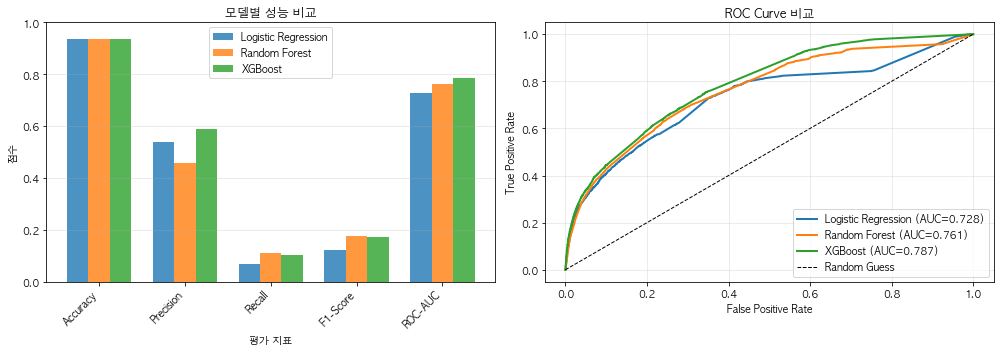


🏆 최고 성능 모델: XGBoost
   ROC-AUC: 0.7871


In [19]:
print("\n" + "="*60)
print("모델 성능 비교")
print("="*60)

import xgboost as xgb

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)


y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


results_df = pd.DataFrame({
    '모델': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr),
                 accuracy_score(y_test, y_pred_rf),
                 accuracy_score(y_test, y_pred_xgb)],
    'Precision': [precision_score(y_test, y_pred_lr),
                  precision_score(y_test, y_pred_rf),
                  precision_score(y_test, y_pred_xgb)],
    'Recall': [recall_score(y_test, y_pred_lr),
               recall_score(y_test, y_pred_rf),
               recall_score(y_test, y_pred_xgb)],
    'F1-Score': [f1_score(y_test, y_pred_lr),
                 f1_score(y_test, y_pred_rf),
                 f1_score(y_test, y_pred_xgb)],
    'ROC-AUC': [roc_auc_score(y_test, y_pred_proba_lr),
                roc_auc_score(y_test, y_pred_proba_rf),
                roc_auc_score(y_test, y_pred_proba_xgb)]
})

print("\n[모델별 성능 지표]")
display(results_df.round(4))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 지표별 비교
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, results_df.iloc[0, 1:], width, label='Logistic Regression', alpha=0.8)
axes[0].bar(x, results_df.iloc[1, 1:], width, label='Random Forest', alpha=0.8)
axes[0].bar(x + width, results_df.iloc[2, 1:], width, label='XGBoost', alpha=0.8)

axes[0].set_xlabel('평가 지표')
axes[0].set_ylabel('점수')
axes[0].set_title('모델별 성능 비교')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1)

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, y_pred_proba_lr):.3f})', linewidth=2)
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})', linewidth=2)
axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)

axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve 비교')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_model_idx = results_df['ROC-AUC'].idxmax()
print(f"\n🏆 최고 성능 모델: {results_df.loc[best_model_idx, '모델']}")
print(f"   ROC-AUC: {results_df.loc[best_model_idx, 'ROC-AUC']:.4f}")


### ROC-AUC
: 이진 분류 모델의 성능을 측정하는 대표적인 지표

모델이 클래스를 얼마나 잘 구별하는지 나타냄

## Baseline xgboost 
비교할 xgboost 필요 !

In [20]:
from xgboost import XGBClassifier

model = XGBClassifier(
    # 의사결정 나무 수 
    n_estimators=300,
    # 최대 깊이
    max_depth=4,
    # 학습률
    learning_rate=0.05,
    # 데이터 중에 80%만 무작위로 뽑아서 사용
    subsample=0.8,
    # 피처도 80%만 무작위로 선택
    colsample_bytree=0.8,
    # 모델이 잘하고 있는지 측정
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### 평가 지표

In [21]:
from sklearn.metrics import roc_auc_score, classification_report

# predict_proba: 모델이 데이터에 대해 실패, 성공 확률 계산
# 그 중 성공(1) 일 확률만 추출
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, model.predict(X_test)))


ROC-AUC: 0.7871116754135977
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     36333
           1       0.60      0.10      0.17      2498

    accuracy                           0.94     38831
   macro avg       0.77      0.55      0.57     38831
weighted avg       0.92      0.94      0.92     38831



In [22]:
import pandas as pd

imp = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

imp.head(10)


is_n_offices_missing              0.322023
is_city_missing                   0.136809
reinvest_rate_next                0.131966
is_reinvest_rate_next_missing     0.083453
relationships                     0.080427
is_first_participants_missing     0.052677
first_participants                0.043628
is_first_raised_amount_missing    0.026203
log1p_first_raised_amount         0.013720
is_n_founding_missing             0.012769
dtype: float32

성공한 스타트업이 실패한 스타트업보다 더 높은 점수를 받을 확률이 약 79%

## Precision@Top-K 계산

In [23]:
import pandas as pd

# 1. 실제값과 확률을 하나의 데이터프레임으로 결합
results = pd.DataFrame({'true': y_test, 'proba': y_pred_proba})

# 2. 확률 기준 내림차순 정렬
results = results.sort_values(by='proba', ascending=False)

# 3. TOP-K Precision 계산 함수
def precision_at_k(df, k):
    cutoff = int(len(df) * k)
    # 상위 cutoff개 행의 실제값 평균(성공률) 반환
    return df['true'].head(cutoff).mean()

# 4. 출력
for k in [0.01, 0.05, 0.10, 0.20]:
    p = precision_at_k(results, k)
    print(f"Top {int(k*100)}% 적중률: {p:.4f}")


Top 1% 적중률: 0.6005
Top 5% 적중률: 0.3740
Top 10% 적중률: 0.2593
Top 20% 적중률: 0.1778


In [24]:
# # Precision@Top-K 함수
# import numpy as np

# def precision_at_k(y_true, y_score, k=0.1):
#     """
#     y_true  : 실제 성공 여부 (0/1)
#     y_score : 모델 예측 성공 확률
#     k       : 상위 비율 (0.05 = 5%, 0.1 = 10%)
#     """
    
#     # 전체 데이터 중 상위 몇명까지 볼것인지 ?
#     cutoff = int(len(y_true) * k)
#     # 모델이 예측한 성공 확률을 내림차순으로 정렬해서 인덱스 가져옴 (cutoff: 상위)
#     top_idx = np.argsort(y_score)[::-1][:cutoff]
#     # 실제 성공 여부의 평균 (precision)
#     return y_true.iloc[top_idx].mean()

# # Top-K별 Precision 계산
# for k in [0.01, 0.05, 0.10, 0.20]:
#     p = precision_at_k(y_test, y_pred_proba, k)
#     print(f"Precision@Top {int(k*100)}% : {p:.4f}")


| 구간      | Precision  | 의미                  |
| ------- | ---------- | ------------------- |
| Top 1%  | **0.6005** | 상위 1% 중 **60%가 성공** |
| Top 5%  | **0.3740** | 상위 5% 중 **37% 성공**  |
| Top 10% | **0.2593** | 상위 10% 중 **26% 성공** |
| Top 20% | **0.1778** | 상위 20% 중 **18% 성공** |


In [29]:
# 무작위로 찍었을 때 대비 몇배가 좋은지 ? 
base_rate = y_test.mean()

print(f"전체 성공률 (Random): {base_rate:.4f}")

for k in [0.01, 0.05, 0.10, 0.20]:
    p = precision_at_k(results, k)
    lift = p / base_rate if base_rate > 0 else 0
    print(f"Top {int(k*100)}% Precision: {p:.4f} | Lift: {lift:.2f}x")


전체 성공률 (Random): 0.0643
Top 1% Precision: 0.6005 | Lift: 9.33x
Top 5% Precision: 0.3740 | Lift: 5.81x
Top 10% Precision: 0.2593 | Lift: 4.03x
Top 20% Precision: 0.1778 | Lift: 2.76x


VC가 상위 5%만 먼저 보면

랜덤 대비 약 6배 효율

상위 10%만 봐도

4배 효율

상위 20%만 봐도

거의 3배 효율

## SHAP

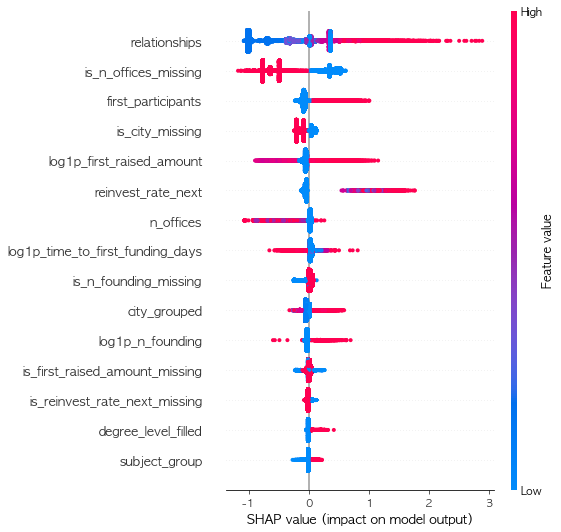

In [30]:
import shap
import numpy as np

# TreeExplainer (XGBoost에 최적)
explainer = shap.TreeExplainer(model)

# SHAP 값 계산 (테스트셋 기준 권장)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    max_display=15
)


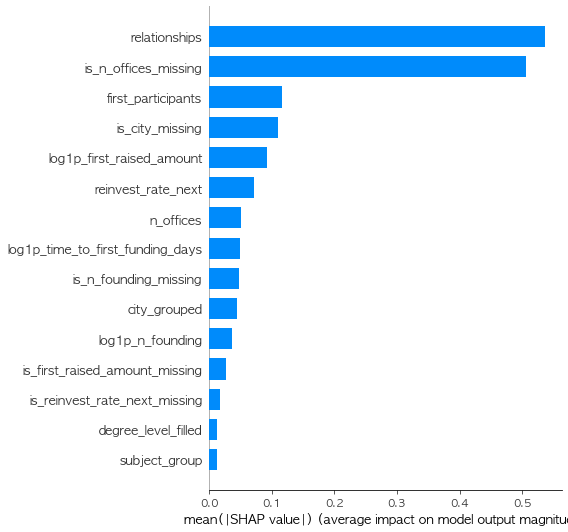

In [31]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    max_display=15
)


### shap 해석
1. relationships
사람·조직·네트워크가 많이 연결된 회사일수록 성공 가능성이 높다
2. is_n_offices_missing
사무실/조직 정보조차 공개되지 않은 스타트업은
성공 확률이 낮다
3. first_participants
초기 라운드에서 여러 투자자가 동시에 참여한 회사는
집단 검증을 통과했을 가능성이 높다
4. is_city_missing
어디서 사업하는지조차 명확하지 않은 스타트업은
VC 관점에서 리스크가 크다
5. log1p_first_raised_amount
초기 투자금은 중요하지만,
그 자체로 성공을 결정하지는 않는다
6. reinvest_rate_next
바로 다음 라운드에서 같은 투자자가 다시 들어왔다는 사실은
가장 강력한 신뢰 신호 중 하나다

## 하이퍼파라미터 튜닝

데이터가 작고 조합이 몇 개 없다면? → GridSearchCV

데이터가 크고 빨리 성능을 내고 싶다면? → RandomizedSearchCV

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier

# 성공/실패 비율 기반 weight (불균형 보정)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "reg_lambda": [1, 5, 10],
    "gamma": [0, 0.5, 1.0],
    "scale_pos_weight": [1, scale_pos_weight],  # 꼭 포함
}

base_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    tree_method="hist"
)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=25,               # 20~40 사이 추천
    scoring="roc_auc",       # AUC로 튜닝
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)
best_xgb = search.best_estimator_


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 10, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Best CV ROC-AUC: 0.7918006257295712


## 튜닝 후 xgboost (튜닝값 적용)

In [33]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=0.7,
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight= 1,
    reg_lambda= 10,
    min_child_weight= 1
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# 이 데이터는 몇 % 확률로 성공할것 같다는 확률 계산 
y_pred_proba = model.predict_proba(X_test)[:, 1]

# y_test: 정답지 y_pred_proba: 모델이 쓴 답
# roc_auc_score: 채점 점수
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, model.predict(X_test)))


ROC-AUC: 0.7876452759929023
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     36333
           1       0.58      0.10      0.17      2498

    accuracy                           0.94     38831
   macro avg       0.76      0.55      0.57     38831
weighted avg       0.92      0.94      0.92     38831



### classification_report

정확도: 0.94 
클래스 0: 정밀도, 재현율 모두 높음. (모델이 실패는 정확하게 잡아냄)

클래스 1: 정밀도 58%, 재현율 10, F1-score: 정밀도와 재현율이 모두 낮아 점수가 낮음.

➡️ 데이터 불균형 문제

근데 성공을 얼마나 잘 맞췄냐의 문제가 아닌 상위 N개 중 성공이 얼마나 들어 있나를 봐야 함.

스타트업 성공은 본질적으로 희귀하고 불확실한 사건이기 때문에,
본 모델은 성공을 ‘단정’하기보다
상대적으로 성공 가능성이 높은 기업을 선별하는
스크리닝 도구로 설계

In [36]:
import pandas as pd

imp = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

imp.head(10)


is_n_offices_missing              0.463549
is_city_missing                   0.132898
reinvest_rate_next                0.111736
relationships                     0.067652
is_first_participants_missing     0.038027
is_reinvest_rate_next_missing     0.035127
is_first_raised_amount_missing    0.031229
first_participants                0.022526
city_grouped                      0.013788
is_n_founding_missing             0.012672
dtype: float32

In [37]:
import pandas as pd

# 1. 실제값과 확률을 하나의 데이터프레임으로 결합
results = pd.DataFrame({'true': y_test, 'proba': y_pred_proba})

# 2. 확률 기준 내림차순 정렬
results = results.sort_values(by='proba', ascending=False)

# 3. TOP-K Precision 계산 함수
def precision_at_k(df, k):
    cutoff = int(len(df) * k)
    # 상위 cutoff개 행의 실제값 평균(성공률) 반환
    return df['true'].head(cutoff).mean()

# 4. 출력
for k in [0.01, 0.05, 0.10, 0.20]:
    p = precision_at_k(results, k)
    print(f"Top {int(k*100)}% 적중률: {p:.4f}")


Top 1% 적중률: 0.6031
Top 5% 적중률: 0.3709
Top 10% 적중률: 0.2629
Top 20% 적중률: 0.1785


proba: 상대적인 성공 가능성 점수

In [38]:
# # Precision@Top-K 함수
# import numpy as np

# def precision_at_k(y_true, y_score, k=0.1):
#     """
#     y_true  : 실제 성공 여부 (0/1)
#     y_score : 모델 예측 성공 확률
#     k       : 상위 비율 (0.05 = 5%, 0.1 = 10%)
#     """
#     cutoff = int(len(y_true) * k)
#     top_idx = np.argsort(y_score)[::-1][:cutoff]
#     return y_true.iloc[top_idx].mean()

# # Top-K별 Precision 계산
# for k in [0.01, 0.05, 0.10, 0.20]:
#     p = precision_at_k(y_test, y_pred_proba, k)
#     print(f"Precision@Top {int(k*100)}% : {p:.4f}")


In [ ]:
# 무작위로 찍었을 때 대비 몇배가 좋은지 ? 
base_rate = y_test.mean()

print(f"전체 성공률 (Random): {base_rate:.4f}")

for k in [0.01, 0.05, 0.10, 0.20]:
    p = precision_at_k(results, k)
    # 모델이 추천한 상위 그룹의 성공률 p가 무작위 성공률(best_rate)보다 몇배 높은지 계산
    lift = p / base_rate if base_rate > 0 else 0
    print(f"Top {int(k*100)}% Precision: {p:.4f} | Lift: {lift:.2f}x")


전체 성공률 (Random): 0.0643
Top 1% Precision: 0.6031 | Lift: 9.37x
Top 5% Precision: 0.3709 | Lift: 5.77x
Top 10% Precision: 0.2629 | Lift: 4.09x
Top 20% Precision: 0.1785 | Lift: 2.77x


모델이 자신있어하는 상위 1%를 뽑았더니 100개 기업 중 60개의 기업이 실제 성공임. 

그냥 무작위로 뽑았을 때보다 모델을 썼을 때 성공확률이 9배가 높음.

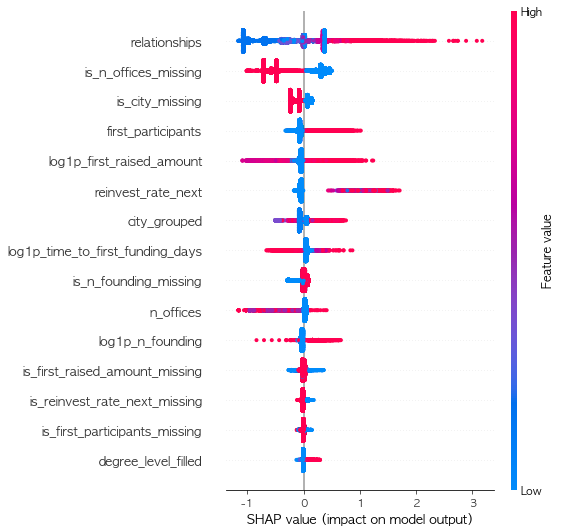

In [40]:
import shap
import numpy as np

# TreeExplainer (XGBoost에 최적)
explainer = shap.TreeExplainer(model)

# SHAP 값 계산 (테스트셋 기준 권장)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    max_display=15
)


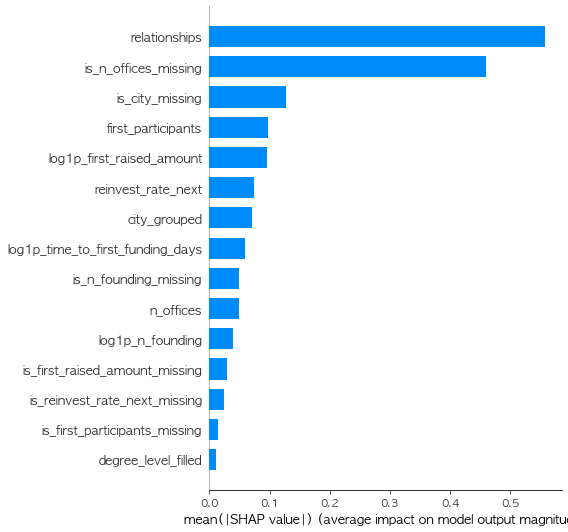

In [41]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    max_display=15
)



Feature Importance 분석

[상위 15개 중요 특성]


,특성,중요도
19,is_n_offices_missing,0.463549
9,is_city_missing,0.132898
6,reinvest_rate_next,0.111736
20,relationships,0.067652
3,is_first_participants_missing,0.038027
7,is_reinvest_rate_next_missing,0.035127
1,is_first_raised_amount_missing,0.031229
2,first_participants,0.022526
8,city_grouped,0.013788
17,is_n_founding_missing,0.012672


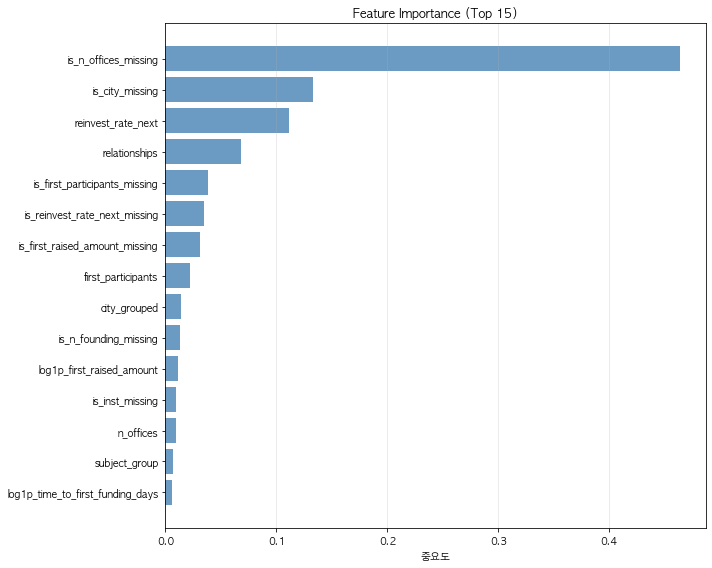

In [42]:
print("\n" + "="*60)
print("Feature Importance 분석")
print("="*60)

feature_importance = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    '특성': feature_names,
    '중요도': feature_importance
}).sort_values('중요도', ascending=False)

print("\n[상위 15개 중요 특성]")
display(importance_df.head(15))

# 시각화
plt.figure(figsize=(10, 8))
top_n = 15
top_features = importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['중요도'], color='steelblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['특성'])
plt.xlabel('중요도')
plt.title(f'Feature Importance (Top {top_n})')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 전체 스타트업의 성공 확률 점수표

In [ ]:
startup_scores = X.copy()
# 전체 데이터의 성공확률 값 컬럼 추가
startup_scores["success_prob"] = model.predict_proba(X)[:, 1]

startup_scores = startup_scores.sort_values(
    "success_prob", ascending=False
)

In [44]:
startup_scores

,log1p_first_raised_amount,is_first_raised_amount_missing,first_participants,is_first_participants_missing,log1p_time_to_first_funding_days,is_time_to_first_funding_days_missing,reinvest_rate_next,is_reinvest_rate_next_missing,city_grouped,is_city_missing,inst_tier,is_inst_missing,subject_group,is_subject_missing,degree_level_filled,is_degree_level_missing,log1p_n_founding,is_n_founding_missing,n_offices,is_n_offices_missing,relationships,success_prob
2188,13.815512,0,2.0,0,0.000000,1,0.0,0,7.0,0,0.0,0,0.0,0,4,0,1.609438,0,4.0,0,101,0.974334
168440,11.512935,0,1.0,0,0.000000,1,0.0,0,10.0,0,0.0,0,1.0,0,3,0,1.098612,0,67.0,0,1046,0.969545
34684,15.363073,0,2.0,0,5.220356,0,0.0,0,10.0,0,0.0,0,3.0,0,3,0,1.386294,0,2.0,0,119,0.968628
39516,0.000000,0,1.0,0,0.000000,1,1.0,0,15.0,0,1.0,0,3.0,0,2,0,1.098612,0,4.0,0,108,0.964981
171418,12.429220,0,1.0,0,0.000000,1,0.0,0,0.0,0,0.0,0,3.0,0,3,0,1.609438,0,3.0,0,94,0.961910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78723,0.000000,1,0.0,1,0.000000,1,0.0,1,1.0,1,0.0,1,2.0,1,-1,1,2.079442,0,1.0,1,1,0.005304
163966,0.000000,1,0.0,1,0.000000,1,0.0,1,1.0,1,0.0,1,2.0,1,-1,1,2.079442,0,1.0,1,1,0.005304
125454,0.000000,1,0.0,1,0.000000,1,0.0,1,1.0,1,0.0,1,2.0,1,-1,1,2.079442,0,1.0,1,1,0.005304
190165,0.000000,1,0.0,1,0.000000,1,0.0,1,1.0,1,0.0,1,2.0,1,-1,1,2.079442,0,1.0,1,1,0.005304


In [47]:
top10 = (
    startup_scores
    .sort_values("success_prob", ascending=False)
    .head(10)
)
top10

,log1p_first_raised_amount,is_first_raised_amount_missing,first_participants,is_first_participants_missing,log1p_time_to_first_funding_days,is_time_to_first_funding_days_missing,reinvest_rate_next,is_reinvest_rate_next_missing,city_grouped,is_city_missing,inst_tier,is_inst_missing,subject_group,is_subject_missing,degree_level_filled,is_degree_level_missing,log1p_n_founding,is_n_founding_missing,n_offices,is_n_offices_missing,relationships,success_prob
2188,13.815512,0,2.0,0,0.000000,1,0.0,0,7.0,0,0.0,0,0.0,0,4,0,1.609438,0,4.0,0,101,0.974334
168440,11.512935,0,1.0,0,0.000000,1,0.0,0,10.0,0,0.0,0,1.0,0,3,0,1.098612,0,67.0,0,1046,0.969545
34684,15.363073,0,2.0,0,5.220356,0,0.0,0,10.0,0,0.0,0,3.0,0,3,0,1.386294,0,2.0,0,119,0.968628
39516,0.000000,0,1.0,0,0.000000,1,1.0,0,15.0,0,1.0,0,3.0,0,2,0,1.098612,0,4.0,0,108,0.964981
171418,12.429220,0,1.0,0,0.000000,1,0.0,0,0.0,0,0.0,0,3.0,0,3,0,1.609438,0,3.0,0,94,0.961910
159718,13.122365,0,2.0,0,5.365976,0,0.5,0,0.0,0,1.0,0,3.0,0,2,0,1.098612,0,3.0,0,269,0.960974
144460,0.000000,0,3.0,0,3.465736,0,0.0,0,16.0,0,0.0,0,3.0,0,4,0,1.945910,0,1.0,0,155,0.957949
2921,15.424949,0,10.0,0,6.148468,0,0.1,0,15.0,0,0.0,0,3.0,0,2,0,1.791759,0,1.0,0,162,0.955043
143166,15.894952,0,1.0,0,6.304449,0,0.0,0,17.0,0,1.0,0,3.0,0,3,0,1.098612,0,1.0,0,246,0.945655
56648,15.717618,0,1.0,0,6.461468,0,0.0,0,16.0,0,1.0,0,3.0,0,3,0,1.386294,0,1.0,0,324,0.934656


In [48]:
df

,objects_cfpr_id,category,city,n_offices,relationships,degree_level,subject,inst,n_founding,is_degree_level_missing,is_n_offices_missing,is_n_founding_missing,degree_level_filled,category_4,log1p_n_offices,log1p_n_founding,log1p_relationships,cluster,success_flag,first_raised_amount,first_participants,first_funded_at,founded_at,founded_at_filled,time_to_first_funding_days,reinvest_rate_next,is_city_missing,is_subject_missing,is_inst_missing,is_first_raised_amount_missing,is_first_participants_missing,is_time_to_first_funding_days_missing,is_reinvest_rate_next_missing,log1p_first_raised_amount,log1p_first_participants,log1p_time_to_first_funding_days,city_grouped,inst_tier,subject_group
0,c:1,web,seattle,2.0,17,2.0,Computer Science / Software,"california, berkeley university",2.0,0,0,0,2,digital product,1.098612,1.098612,2.890372,1,1,5250000.0,2.0,2005-10-01,2005-10-17,2005-10-17,0.0,1.0,0,0,0,0,0,1,0,15.473739,1.098612,0.000000,17.0,1.0,3.0
1,c:10,games_video,culver city,1.0,6,2.0,Computer Science / Software,michigan university,2.0,0,0,0,2,digital product,0.693147,1.098612,1.945910,1,1,0.0,0.0,NaT,NaT,NaT,0.0,0.0,0,0,0,1,1,1,1,0.000000,0.000000,0.000000,0.0,0.0,3.0
2,c:100,games_video,san mateo,1.0,12,4.0,Computer Science / Software,stanford university,1.0,0,0,0,4,digital product,0.693147,0.693147,2.564949,1,1,0.0,0.0,NaT,NaT,NaT,0.0,0.0,0,0,0,1,1,1,1,0.000000,0.000000,0.000000,0.0,1.0,3.0
3,c:10000,network_hosting,Unknown,1.0,0,NaN,Unknown,Unknown,1.0,1,1,1,-1,digital product,0.693147,0.693147,0.000000,0,0,0.0,0.0,NaT,2008-07-26,2008-07-26,0.0,0.0,1,1,1,1,1,1,1,0.000000,0.000000,0.000000,1.0,0.0,2.0
4,c:10001,games_video,Unknown,1.0,0,NaN,Unknown,Unknown,1.0,1,1,1,-1,digital product,0.693147,0.693147,0.000000,0,0,0.0,0.0,NaT,2008-07-26,2008-07-26,0.0,0.0,1,1,1,1,1,1,1,0.000000,0.000000,0.000000,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194146,c:99940,ecommerce,san francisco,1.0,5,NaN,Unknown,Unknown,1.0,1,0,1,-1,digital product,0.693147,0.693147,1.791759,0,0,0.0,0.0,NaT,2007-01-01,2007-01-01,0.0,0.0,0,1,1,1,1,1,1,0.000000,0.000000,0.000000,15.0,0.0,2.0
194147,c:9995,public_relations,san jose,1.0,14,NaN,Unknown,Unknown,1.0,1,0,1,-1,others,0.693147,0.693147,2.708050,2,0,750000.0,0.0,2008-08-25,2007-11-01,2007-11-01,298.0,0.0,0,1,1,0,0,0,1,13.527830,0.000000,5.700444,16.0,0.0,2.0
194148,c:9996,consulting,falls church,1.0,44,NaN,Unknown,Unknown,1.0,1,0,1,-1,others,0.693147,0.693147,3.806662,2,0,0.0,0.0,NaT,1959-01-01,1959-01-01,0.0,0.0,0,1,1,1,1,1,1,0.000000,0.000000,0.000000,0.0,0.0,2.0
194149,c:9997,search,los angeles,1.0,1,NaN,Unknown,Unknown,1.0,1,0,1,-1,digital product,0.693147,0.693147,0.693147,0,0,0.0,0.0,NaT,2008-07-01,2008-07-01,0.0,0.0,0,1,1,1,1,1,1,0.000000,0.000000,0.000000,9.0,0.0,2.0


In [ ]:
# ! pip install joblib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [51]:
import joblib
print(joblib.__version__)

1.5.2


In [52]:
joblib.dump(model, "xgb_model.pkl")

['xgb_model.pkl']

In [53]:
joblib.dump(enc, "ordinal_encoder.pkl")

['ordinal_encoder.pkl']

In [54]:
feature_cols = X_train.columns.tolist()
joblib.dump(feature_cols, "feature_cols.pkl")

['feature_cols.pkl']

In [55]:
import shap
import numpy as np
import pandas as pd

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X)

# XGBoost binary일 때
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # positive class

# shap_global: 성공에 가장 중요한 변수 Top N
shap_global = (
    pd.DataFrame({
        "feature": X.columns,
        "mean_abs_shap": np.abs(shap_values).mean(axis=0)
    })
    .sort_values("mean_abs_shap", ascending=False)
)

shap_global.to_csv("shap_global.csv", index=False)

# shap_local: 이 회사는 왜 이런 점수를 받았는가?
shap_df = pd.DataFrame(
    shap_values,
    columns=X.columns,
    index=df["objects_cfpr_id"]
).reset_index().rename(columns={"index": "objects_cfpr_id"})

shap_df.to_csv("shap_local.csv", index=False)


In [ ]:
import pandas as pd

df = pd.read_csv("/mnt/data/df.csv")
startup_scores = pd.read_csv("/mnt/data/startup_scores.csv")

# 1) 점수 dict 만들기 (ID → success_prob)
score_map = startup_scores.set_index("objects_cfpr_id")["success_prob"]

def apply_filter(df, vc_cluster_id):
    # 예시 규칙 (너가 원하는 대로 수정)
    if vc_cluster_id == 4:      # seed 성향 VC
        return df[(df["first_participants"] <= 2) & (df["log1p_first_raised_amount"] <= 13.0)]
    elif vc_cluster_id == 1:    # 후기 성향 VC
        return df[(df["log1p_first_raised_amount"] >= 15.0) & (df["first_participants"] >= 2)]
    else:
        return df.copy()

def recommend_for_vc(vc_cluster_id, top_n=10):
    cand = apply_filter(df, vc_cluster_id).copy()
    # 2) 여기서만 점수 붙임 (df 원본은 안 변함)
    cand["success_prob"] = cand["objects_cfpr_id"].map(score_map)
    # 3) 점수 없는 애 제거 후 정렬
    cand = cand.dropna(subset=["success_prob"])
    return cand.sort_values("success_prob", ascending=False).head(top_n)

# 사용
top10_vc4 = recommend_for_vc(4, top_n=10)
top10_vc4[["objects_cfpr_id","success_prob","category_4","city_grouped","first_participants","first_raised_amount"]]


In [ ]:
startup_scores["success_prob"] = xgb.predict_proba(X)[:,1]

In [ ]:
# vc 클러스터 정의
vc_startup_filter = {
    0: {"max_stage": "seed", "max_rounds": 1},
    1: {"min_stage": "series_b"},
    2: {"stage_range": ["series_a", "series_b"], "require_followon": True},
    3: {"round_type": "debt_round"},
    4: {"stage": "seed"},
    5: {"stage": "series_a"}
}

In [ ]:
def recommend_for_vc(vc_cluster_id, top_n=10):
    filtered = apply_filter(
        startup_df,
        vc_startup_filter[vc_cluster_id]
    )
    return (
        filtered
        .sort_values("success_score", ascending=False)
        .head(top_n)
    )
